# Examples for Voigt profiles (v1.2)

In [29]:
%matplotlib inline

In [30]:
### import
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.analysis import voigt as lav
# plots
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 6.0)
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

In [31]:
# Define a plotting function
def plt_line(spec):
    plt.clf()
    plt.figure(dpi=1200)
    plt.plot(spec.wavelength.value, spec.flux.value, 'k-', drawstyle='steps-mid', lw=1.5)
    plt.xlim(3644., 3650.)
    plt.ylabel('Normalized Flux', fontsize=20.)
    plt.xlabel('Wavelength', fontsize=20.)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(2.))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylim(0., 1.1)
    plt.show()
    plt.close()

## Generate a Ly$\alpha$ line

In [32]:
abslin = AbsLine(1215.670*u.AA)

## Fill attributes

In [33]:
abslin.attrib['N'] = 10**14./u.cm**2  # log N
abslin.attrib['b'] = 25.*u.km/u.s
abslin.attrib['z'] = 2.0

## Generate Voigt profile

### Use wavelength from spectrum

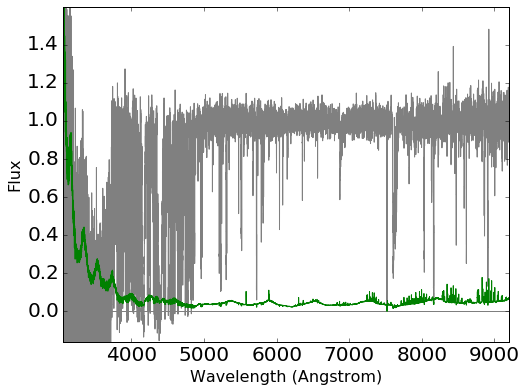

In [34]:
#Load
abslin.analy['spec'] = lsio.readspec('../../linetools/spectra/tests/files/UM184_nF.fits')
abslin.analy['spec'].plot()

In [37]:
#Generate
vmodel = abslin.generate_voigt()
vmodel.wavelength

<Quantity [ 3056.66739052, 3056.89170954, 3057.11604502,...,
            9203.90467017, 9204.58011522, 9205.25560984] Angstrom>

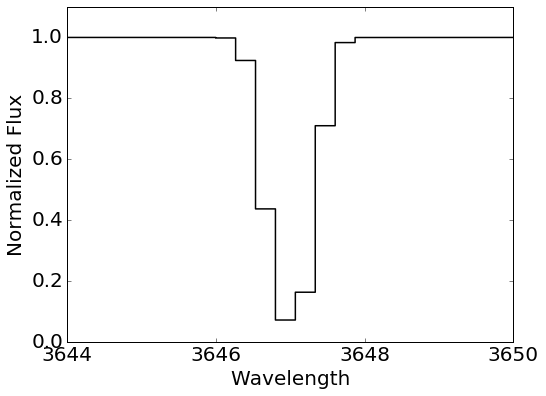

(<Quantity [ 0.38912098, 0.38914953, 0.38917809, 0.38920665, 0.38923522,
             0.38926378, 0.38929235, 0.38932092, 0.38934949, 0.38937806] Angstrom>,
 <Quantity [ 19.18471221, 19.1837049 , 19.18269746, 19.18168989,
             19.18068219, 19.17967437, 19.17866642, 19.17765834,
             19.17665014, 19.17564181] km / s>)

In [36]:
# Plot
plt_line(vmodel)
import numpy as np
relativistic_equiv = u.doppler_relativistic(1215.670*u.AA*(1+2.0))
vmodel.velo = vmodel.wavelength.to(u.km/u.s,equivalencies=relativistic_equiv)
(vmodel.wavelength - np.roll(vmodel.wavelength,1))[len(vmodel.wavelength)/2-5:len(vmodel.wavelength)/2+5],(vmodel.velo - np.roll(vmodel.velo,1))[len(vmodel.velo)/2-5:len(vmodel.velo)/2+5]

### Use self-generated wavelength

In [10]:
abslin.attrib['N'] = 10**17.5/u.cm**2
abslin.attrib['b'] = 20.*u.km/u.s

In [11]:
import numpy as np
wave = np.linspace(3630,3660,30)*u.AA

In [12]:
vmodel2 = abslin.generate_voigt(wave=wave)

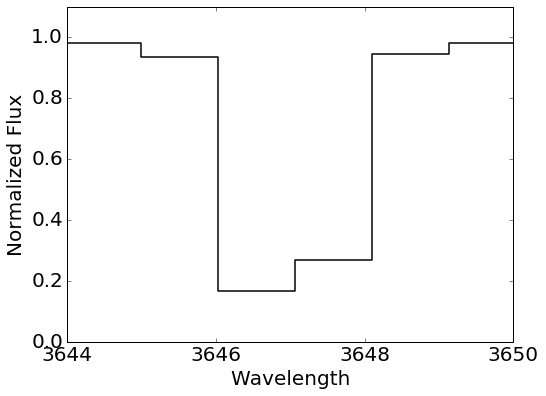

In [13]:
plt_line(vmodel2)

In [14]:
wave
(3648.6207-3647.5862)/3648.6207*299792

85.00056583023986

## Multiple Lines

In [15]:
abslin2 = AbsLine('DI 1215')
abslin2.attrib['N'] = 10**13./u.cm**2  # log N
abslin2.attrib['b'] = 15.*u.km/u.s
abslin2.attrib['z'] = 2.0

In [16]:
vmodel3 = lav.voigt_from_abslines(wave,[abslin,abslin2])

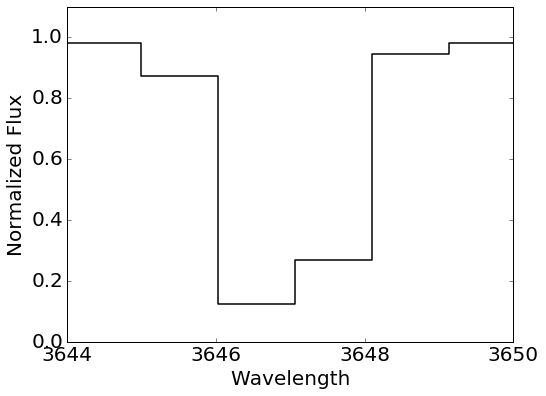

In [17]:
plt_line(vmodel3)

## $\tau$ Profiles

In [18]:
tau = lav.voigt_from_abslines(wave,abslin,ret='tau')

/Users/lwymarie/python/linetools/linetools/analysis/voigt.py:220: UserWarning: Rebinned tau back to your input array.  Reconsider input
  warnings.warn('Rebinned tau back to your input array.  Reconsider input')


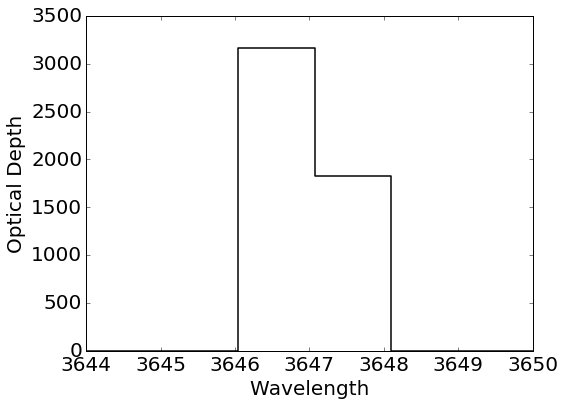

In [19]:
#
plt.clf()
plt.figure(dpi=1200)
plt.plot(wave,tau, 'k-', drawstyle='steps-mid', lw=1.5)
plt.xlim(3644., 3650.)
plt.ylabel('Optical Depth', fontsize=20.)
plt.xlabel('Wavelength', fontsize=20.)
plt.show()
plt.close()

## Fit the Voigt

In [20]:
from astropy.modeling import fitting

In [21]:
fitvoigt = lav.single_voigt_model(logN=np.log10(abslin.attrib['N'].value),b=abslin.attrib['b'].value,
                                z=abslin.attrib['z'], wrest=abslin.wrest.value, 
                                gamma=abslin.data['gamma'].value, f=abslin.data['f'],
                                 fwhm=3.)

In [22]:
fitter = fitting.LevMarLSQFitter()

In [23]:
p = fitter(fitvoigt,wave.value,vmodel2.flux.value,weights=1./(np.ones(len(wave))*0.1))
print(p)

Model: single_voigt_model
Inputs: (u'wave',)
Outputs: (u'flux',)
Model set size: 1
Parameters:
         logN           b             z        wrest    f       gamma    fwhm
    ------------- ------------- ------------- ------- ------ ----------- ----
    17.4971753856 18.1933650266 1.99999986168 1215.67 0.4164 626500000.0  3.0


/Users/lwymarie/python/linetools/linetools/analysis/voigt.py:279: RuntimeWarning: overflow encountered in exp
  fx = np.exp(-1*tau)


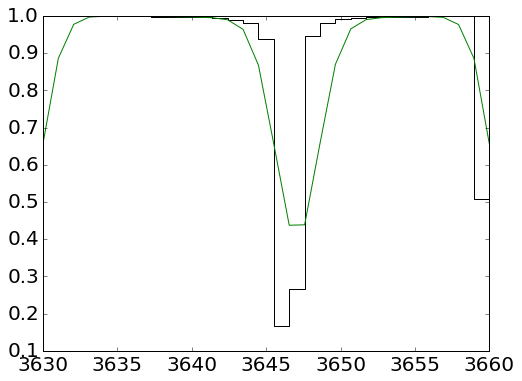

In [24]:
#
plt.clf()
plt.plot(wave, vmodel2.flux, 'k-',drawstyle='steps')
plt.plot(wave,p(wave.value), 'g-')
#xdb.xplot(wave,model.flux,p(wave.value))
plt.show()
plt.close()
# note the bad pixels at either end of the spectrum - this is a bug! It can't be 
# worked around for now by making sure that the spectrum is much larger than the region
# of interest, and discarding the first and last ~10 pixels.

## Test Voigt Models for Speed and Accuracy

In [23]:
import timeit

### Benchmark for accuracy

In [24]:
def voigt_slow(a, u):
    """ Calculate the voigt function to very high accuracy.
    Uses numerical integration, so is slow.  Answer is correct to 20
    significant figures.
    Note this needs `mpmath` or `sympy` to be installed.
    """
    try:
        import mpmath as mp
    except ImportError:
        from sympy import mpmath as mp
    with mp.workdps(20):
        z = mp.mpc(u, a)
        result = mp.exp(-z*z) * mp.erfc(-1j*z)

    return result.real

In [25]:
# This cell takes a few minutes to run.

a = 0.05
alluvoigt = np.linspace(0.,5.,1000)
true_voigt05 = []
%timeit -r 10 for uvoigt in alluvoigt: true_voigt05.append(voigt_slow(a,uvoigt))
# Just take first 1000
true_voigt05 = np.array(true_voigt05[0:1000])

1 loop, best of 10: 616 ms per loop


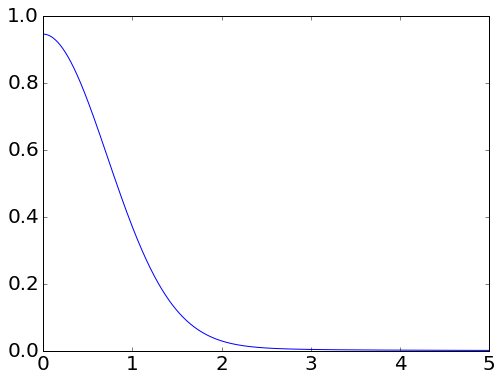

In [26]:
# Plot
plt.clf()
plt.plot(alluvoigt, true_voigt05, '-')
plt.show()
plt.close()

### VoigtKing

#### Speed

In [27]:
%timeit -r 10 king_voigt05 = lav.voigtking(alluvoigt,a)

1000 loops, best of 10: 270 µs per loop


#### Accuracy

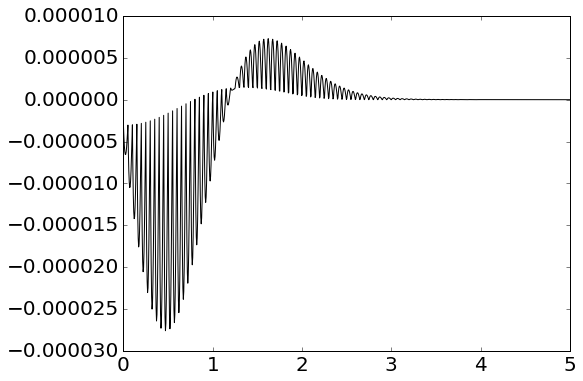

In [28]:
king_voigt05 = lav.voigtking(alluvoigt,a)
plt.clf()
plt.plot(alluvoigt, king_voigt05-true_voigt05, 'k-')
plt.show()
plt.close()

### Scipy

In [29]:
from scipy.special import wofz
def voigt_wofz(u,a):
    return wofz(u + 1j * a).real

#### Speed

In [30]:
%timeit -r 10 wofz_voigt05 = voigt_wofz(alluvoigt,a)

1000 loops, best of 10: 164 µs per loop


#### Accuracy

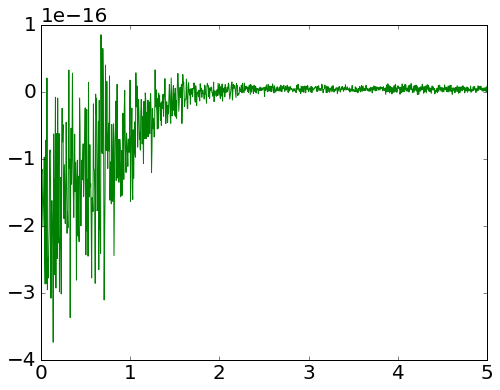

In [31]:
wofz_voigt05 = voigt_wofz(alluvoigt,a)
#
plt.clf()
plt.plot(alluvoigt, wofz_voigt05-true_voigt05, 'g-')
plt.show()
plt.close()

In [25]:
abslin1_comp1 = AbsLine(1548.195*u.AA)
abslin1_comp1.attrib['N'] = 10**13.8253/u.cm**2 
abslin1_comp1.attrib['b'] = 165.73*u.km/u.s
abslin1_comp1.attrib['z'] = 0.00033149
#abslin2_comp1 = AbsLine(1550.770*u.AA)
#abslin2_comp1.attrib['N'] = abslin1_comp1.attrib['N']
#abslin2_comp1.attrib['b'] = abslin1_comp1.attrib['b']
#abslin2_comp1.attrib['z'] = abslin1_comp1.attrib['z']
abslin1_comp2 = AbsLine(1548.195*u.AA)
abslin1_comp2.attrib['N'] = 10**13.9664/u.cm**2
abslin1_comp2.attrib['b'] = 192.64*u.km/u.s
abslin1_comp2.attrib['z'] = 0.00171209
#abslin2_comp2 = AbsLine(1550.770*u.AA)
#abslin2_comp2.attrib['N'] = abslin1_comp2.attrib['N']
#abslin2_comp2.attrib['b'] = abslin1_comp2.attrib['b']
#abslin2_comp2.attrib['z'] = abslin1_comp2.attrib['z']
import linetools.utils as ltu
velo = np.linspace(-3000,3000,61)*u.km/u.s
wave =1548.195*u.AA*(1+ltu.z_from_v(0,velo))
vmodel = lav.voigt_from_abslines(wave,[abslin1_comp1,abslin1_comp2])
tau = lav.voigt_from_abslines(wave,[abslin1_comp1,abslin1_comp2],ret='tau')
def plt_line(spec):
    plt.clf()
    plt.figure(dpi=1200)
    plt.plot(spec.wavelength.value, spec.flux.value, 'k-', drawstyle='steps-mid', lw=1.5)
    plt.xlim(wave[0]/u.AA,wave[-1]/u.AA)
    plt.ylabel('Normalized Flux', fontsize=20.)
    plt.xlabel('Wavelength', fontsize=20.)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(2.))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylim(0., 1.1)
    plt.show()
    plt.close()
vcen = np.sum(velo*tau)/np.sum(tau)
vdisp = np.sqrt(np.sum((velo-vcen)**2*tau)/np.sum(tau))
print('tau weighted mean, dispersion =',vcen,vdisp)

('tau weighted mean, dispersion =', <Quantity 339.4636090635604 km / s>, <Quantity 242.90267467091064 km / s>)


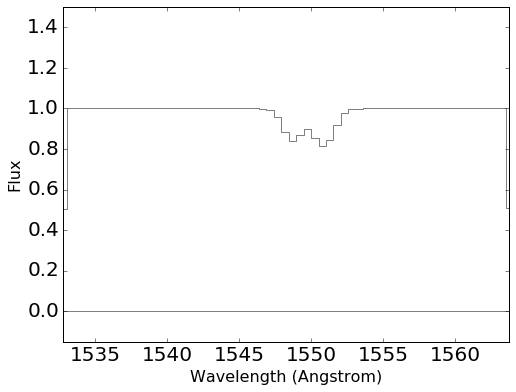

In [28]:
vmodel.plot()

In [78]:
np.array?